# Preliminary analysis notebook: Analysis of SSH data during storm events, focusing on Hurricane Maria

@Authors: [Franck Porteous](https://github.com/FranckPrts), [Faith Hunja](https://github.com/faithhunja), [Hannah Krohn](https://github.com/hlili303)

### Setup

#### Imports

In [10]:
# imports
import matplotlib.pyplot as plt
import xarray as xr
import os
import pooch
import tempfile
import pandas as pd
import numpy as np
from scipy import stats

from pooch import HTTPDownloader
import xarray as xr
import os
from datetime import timedelta, datetime

from cartopy import crs as ccrs

#### Colors & Repo

In [11]:
colors = {
    "blue": "#1f77b4",
    "orange": "#ff7f0e",
    "green": "#2ca02c",
    "red": "#d62728",
    "purple": "#9467bd",
    "brown": "#8c564b",
    "pink": "#e377c2",
    "gray": "#7f7f7f",
    "olive": "#bcbd22",
    "cyan": "#17becf"
}

In [12]:
storm_repo = {
    
             "Sandy":{"start_date": datetime(2012, 10, 21), 
                      "end_date": datetime(2012, 10, 31),
                      "tide": "Spring",
                      "duration": 10,
                      "maxIntensity_kt": 100,
                      "maxIntensity_mb": 940,
                      "tg": {"Atlantic City, NJ": {"lat": 39.35500, "lon": -74.41800},
                            "Montauk, NY": {"lat": 40.693, "lon": -72.049},
                            "The Battery, NY": {"lat": 40.701, "lon": -74.014}},
                      
                      "tg_precise": {"Atlantic City, NJ (precise)": {"lat": 39.35500, "lon": -74.41800},
                            "Montauk, NY (precise)": {"lat": 40.693, "lon": -72.049},
                            "The Battery, NY (precise)": {"lat": 40.701, "lon": -73.75}}
                    },
              
             "Maria":{"start_date": datetime(2017, 9, 16), 
                      "end_date": datetime(2017, 10, 2),
                      "tide": "Spring",
                      "duration": 17,
                      "maxIntensity_kt": 150,
                      "maxIntensity_mb": 908,
                      "tg": {"Penuelas, PR": {"lat": 17.972, "lon": -66.762},
                            "Isabel Segunda, PR": {"lat": 18.152, "lon": -65.443},
                            "Esperanza, PR": {"lat": 18.093, "lon": -65.47},
                            "Arecibo, PR": {"lat": 18.48, "lon": -66.702},
                            "Mayaguez, PR": {"lat": 18.22, "lon": -67.16},
                            "Fajardo, PR": {"lat": 18.333, "lon": -65.633}},

                      "tg_precise": {"Penuelas, PR (precise)": {"lat": 17.4, "lon": -66.762},
                            "Isabel Segunda, PR (precise)": {"lat": 18.152, "lon": -65.443},
                            "Esperanza, PR (precise)": {"lat": 18.093, "lon": -65.47},
                            "Arecibo, PR (precise)": {"lat": 18.5, "lon": -66.702},
                            "Mayaguez, PR (precise)": {"lat": 18.22, "lon": -67.16},
                            "Fajardo, PR (precise)": {"lat": 18.333, "lon": -65.633}}
                    }, 
              
             "Ketsana":{"start_date": datetime(2009, 9, 25), 
                      "end_date": datetime(2009, 9, 30),
                      "tide": "Neap",
                      "duration": 5,
                      "maxIntensity_kt": 90,
                      "maxIntensity_mb": 955,
                      "tg": {"Malakal, Palau": {"lat": 7.33000, "lon": 134.46300},
                            "Legaspi, Philippines": {"lat": 13.15000, "lon": 123.75000},
                            "Manila, Philippines": {"lat": 14.58500 , "lon": 120.96800},
                            "Subic Bay, Philippines": {"lat": 14.76500 , "lon": 120.25200},
                            "Qui Nhon, Vietnam": {"lat": 13.77500, "lon": 109.25500}},
                      "tg_precise": {"Malakal, Palau (precise)": {"lat": 7.33000, "lon": 134.46300},
                            "Legaspi, Philippines (precise)": {"lat": 13.15000, "lon": 124.1},
                  #          "Manila, Philippines (precise)": {"lat": 14.58500 , "lon": 120.96800},
                            "Subic Bay, Philippines (precise)": {"lat": 14.76500 , "lon": 119.9},
                            "Qui Nhon, Vietnam (precise)": {"lat": 13.77500, "lon": 109.25500}}
                    }
             }
tg_repo = {"Sandy": {"Atlantic City, NJ": "https://uhslc.soest.hawaii.edu/data/netcdf/fast/hourly/h264.nc"},
           "Maria": {"Penuelas, PR": "https://uhslc.soest.hawaii.edu/data/netcdf/rqds/atlantic/hourly/h243a.nc",
                    "Isabel Segunda, PR": "https://uhslc.soest.hawaii.edu/data/netcdf/rqds/atlantic/hourly/h732a.nc",
                     "Esperanza, PR":"https://uhslc.soest.hawaii.edu/data/netcdf/rqds/atlantic/hourly/h733a.nc",
                     "Arecibo, PR":"https://uhslc.soest.hawaii.edu/data/netcdf/rqds/atlantic/hourly/h735a.nc",
                     "Mayaguez, PR":"https://uhslc.soest.hawaii.edu/data/netcdf/rqds/atlantic/hourly/h736a.nc",
                     "Fajardo, PR":"https://uhslc.soest.hawaii.edu/data/netcdf/rqds/atlantic/hourly/h783b.nc"},
           "Ketsana": {"Malakal, Palau":"https://uhslc.soest.hawaii.edu/data/netcdf/rqds/pacific/hourly/h007b.nc",
                      "Legaspi, Philippines":"https://uhslc.soest.hawaii.edu/data/netcdf/rqds/pacific/hourly/h371a.nc",
                      "Manila, Philippines":"https://uhslc.soest.hawaii.edu/data/netcdf/rqds/pacific/hourly/h370a.nc",
                      "Subic Bay, Philippines":"https://uhslc.soest.hawaii.edu/data/netcdf/rqds/pacific/hourly/h382a.nc",
                      "Qui Nhon, Vietnam":"https://uhslc.soest.hawaii.edu/data/netcdf/rqds/pacific/hourly/h381b.nc"}
          }

#### Helper function

##### time_series_corr()

In [13]:
def time_series_corr(tg_data_dict, sat_data_dict, event, normalize_zero=True):
    """
    Calculate the Pearson correlation between tidal gauge (TG) and satellite (SAT) sea level time series for a given event.

    Parameters:
        tg_data_dict (dict): Dictionary containing tidal gauge data for different events and locations.
        sat_data_dict (dict): Dictionary containing satellite data for different events and locations.
        event (str): Event identifier.
        normalize_zero (bool, optional): Whether to normalize data to have zero mean. Defaults to True.

    Returns:
        pd.DataFrame: DataFrame containing correlation results, including Pearson's correlation coefficient,
                      p-value, minimum and maximum values of TG and SAT data, and percentage of usable data.

    Note:
        Regarding, the sampling frequency of both timeseries. The function assumes that the input data has been preprocessed to ensure compatibility between TG and SAT data.

    """

    results = pd.DataFrame(columns=["Event", "Location", 'Pearons Statistic', 'Pvalue', 'Min TG', 'Max TG', "Min SAT", "Max SAT", "Percent_usable"])

    event_tg_data = tg_data_dict.get(event, None)
    event_sat_data = sat_data_dict.get(event, None)
    
    if event_tg_data is None:
        print(f"Event '{event}' not found in the TG dictionary.")
        return
    if event_sat_data is None:
        print(f"Event '{event}' not found in the SATELLITE dictionary.")
        return

    for idx, (location, tg_values) in enumerate(event_tg_data.items()):
        if len(tg_values.shape) == 2:
            # Convert 2D array to 1D by taking the mean along axis 0 (columns)
            tg_values = np.mean(tg_values, axis=0)

        if normalize_zero: # No need to normalize the SSH data from the sat as it's already anomalies
            tg_values = tg_values - tg_values.mean()
        
        # Find corresponding sat_data and plot its time series
        if location in event_sat_data:
            sat_values = event_sat_data[location]
            time_sat = np.arange(0, len(sat_values)) * 24  # Convert days to hours for x-axis
            sat_values = np.interp(np.arange(len(tg_values)), time_sat, sat_values)  # Resample SAT data to hourly timescale
            
            if normalize_zero:
                sat_values = sat_values - sat_values.mean()
        else:
            sat_values = np.full_like(tg_values, np.nan)  # If SAT data is missing, fill with NaNs

        bad = ~np.logical_or(np.isnan(tg_values), np.isnan(sat_values))
        
        percent_usable = (bad.sum() * 100 / len(bad))

        try:
            res = stats.pearsonr(np.compress(bad, tg_values), np.compress(bad, sat_values))
        except:
            res = ("TOO SHORT", "TOO SHORT")

        row = [event, location, res[0], res[1], tg_values.min(), tg_values.max(), sat_values.min(), sat_values.max(), percent_usable]
        results.loc[len(results)] = row

    return results


##### function: plot_time_series_combined

In [14]:
def plot_time_series_combined(
    tg_data_dict, 
    sat_data_dict, 
    event, 
    baseline_dict=True, 
    normalize_zero=True,
    has_been_resampled = False,
    xlab="xlab", ylab="ylab", type_sensor='sensor'):

    event_tg_data = tg_data_dict.get(event, None)
    event_sat_data = sat_data_dict.get(event, None)
    
    if event_tg_data is None:
        print(f"Event '{event}' not found in the TG dictionary.")
        return
    if event_sat_data is None:
        print(f"Event '{event}' not found in the SATELLITE dictionary.")
        return

    # Create a plot for the time series
    plt.figure(figsize=(12, 6))

    for idx, (location, tg_values) in enumerate(event_tg_data.items()):
        # Assuming tg_values is a NumPy array or a list
        if len(tg_values.shape) == 2:
            # Convert 2D array to 1D by taking the mean along axis 0 (columns)
            tg_values = np.mean(tg_values, axis=0)

        time_tg = range(len(tg_values))


        if normalize_zero: 
            tg_values = tg_values - tg_values.mean()
        
        if has_been_resampled: 
            time_tg = np.arange(0, len(tg_values)) * 24  # Convert days to hours for x-axis
            plt.plot(time_tg, tg_values, color=colors[list(colors.keys())[idx]], label=f"{location} - TG Time Series")

        else:
            # Plot the tg_data time series
            plt.plot(time_tg, tg_values, color=colors[list(colors.keys())[idx]], label=f"{location} - TG Time Series")

        # Find corresponding sat_data and plot its time series
        if location in event_sat_data:
            sat_values = event_sat_data[location]
            
            if normalize_zero:
                sat_values = sat_values - sat_values.mean()
            
            time_sat = np.arange(0, len(sat_values)) * 24  # Convert days to hours for x-axis
            plt.plot(time_sat, sat_values, linestyle='dashed', color=colors[list(colors.keys())[idx]], label=f"{location} - SAT Time Series")

    # Set plot properties
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.title(f"Time Series for Event: {event} [{type_sensor}]")
    plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
    plt.grid(True)

    # Show the plot
    plt.show()

##### function: get_baseline_date()

In [15]:
# helper functions
def get_baseline_date(ref_date, date_meaning):
    
    if date_meaning == "start":
        
        # Get the date 2 months prior to ref_date
        bound1 = ref_date - timedelta(days=60)
        # Get the date 1 month prior to ref_date
        bound2 = ref_date - timedelta(days=30)
        
        
    elif date_meaning == "end":
        # Get the date 1 month post ref_date
        bound1 = ref_date + timedelta(days=30)
        # Get the date 2 months after ref_date
        bound2 = ref_date + timedelta(days=60)
    else:
        raise ValueError("Invalid date_meaning. Use 'start' or 'end'.")

    return bound1, bound2

##### function: get_ds_for_date_range()

In [36]:
# Specify your username and password here
auth=('username', 'password')

In [16]:
def get_ds_for_date_range(start_date, end_date, auth=auth):
    
    # Calculate the number of days in the range
    num_days = (end_date - start_date).days + 1

    datasets = []

    for i in range(num_days):
        date_req = (start_date + timedelta(days=i)).strftime("%Y-%m-%d")

        ecco_url = "https://ecco.jpl.nasa.gov/drive/files/Version4/Release4b/latlon/daily/SSH"
        file_req = f"SEA_SURFACE_HEIGHT_day_mean_{date_req}_ECCO_V4r4b_latlon_0p50deg.nc"
        
        if not os.path.exists("./data/{}".format(file_req)):
            
            fn = os.path.join(ecco_url, file_req)

            # let the downloader know the login credentials
            downloader = HTTPDownloader(auth=auth)
            downloader(url=fn, output_file="./data/{}".format(file_req), pooch=None)

            dataset = xr.open_dataset("./data/{}".format(file_req))
            datasets.append(dataset)

        else:
            dataset = xr.open_dataset("./data/{}".format(file_req))
            datasets.append(dataset)
            

    return xr.concat(datasets, dim="time")


##### plot_bland_altman()

In [17]:
def plot_bland_altman(event, locat, ar_allLoc_allEvent_tg, ar_allLoc_allEvent_sat, save_fig=True, plot_fig=True):
    tidal_gauge = ar_allLoc_allEvent_tg[event][locat]
    satellite_altimetry = ar_allLoc_allEvent_sat[event][locat]

    differences = tidal_gauge - satellite_altimetry

    if len(differences) == 0 or np.all(np.isnan(differences)):
        # If differences list is empty or filled with nan values, print 'No data' at the center of the plot
        fig, ax = plt.subplots()
        ax.text(0.5, 0.5, 'No data', fontsize=12, ha='center', va='center')
        ax.axis('off')
        plt.title(f'No Data for {event} at {locat}')
    else:
        mean_difference = np.nanmean(differences)
        std_difference = np.nanstd(differences)
        upper_limit = mean_difference + 1.96 * std_difference
        lower_limit = mean_difference - 1.96 * std_difference

        plt.scatter(np.mean([tidal_gauge, satellite_altimetry], axis=0), differences)
        plt.axhline(mean_difference, color='red', linestyle='--', label='Mean Difference')
        plt.axhline(upper_limit, color='orange', linestyle='--', label='Upper Limit')
        plt.axhline(lower_limit, color='orange', linestyle='--', label='Lower Limit')
        plt.xlabel('Mean of Tidal Gauge and ECCO Altitude')
        plt.ylabel('Difference (Tidal Gauge - ECCO Altitude)')
        plt.title(f'Bland-Altman Plot for {event} at {locat}')
        plt.legend()
        plt.grid(True)

    if save_fig:
        figure_dir = './figures/'
        os.makedirs(figure_dir, exist_ok=True)

        plot_filename = f'bland_altman_{event}_{locat.replace(", ", "_")}.png'
        plt.savefig(os.path.join(figure_dir, plot_filename))
    if plot_fig:
        plt.show()
    else:
        plt.close()

## First, getting the satellite data

In [18]:
# Init a dict where the data for all event / locaiton are stored 

## At the lowest level, the the dict ds_allLoc_allEvent will only contain the 
## data of a given event (timewise), for a precise location (nearest - we use 
## the tg_precise for sampling the SSH)


doingBaselines = True 

ds_allLoc_allEvent_sat = {} # store the ds
ar_allLoc_allEvent_sat = {} # just store the array
bl_allLoc_allEvent_sat = {} # store the baseline arrays

for event in storm_repo.keys():   
#for event in ["Sandy"]:   

    print("\ndoing: {}".format(event))
    
    start_date = storm_repo[event]["start_date"]
    end_date   = storm_repo[event]["end_date"]

    ds = get_ds_for_date_range(start_date, end_date)

    if doingBaselines:
        b1_start, b1_end = get_baseline_date(start_date, "start")
        b2_start, b2_end = get_baseline_date(end_date, "end")

        ds_baseline_1 =  get_ds_for_date_range(b1_start, b1_end)
        ds_baseline_2 =  get_ds_for_date_range(b2_start, b2_end)
    
    ds_loc = {}
    ar_loc = {}
    bl_loc = {}
    
    for loc in storm_repo[event]["tg_precise"].keys():
        
        print("—— {}\t\tlat: {}\tlon: {}".format(loc, storm_repo[event]["tg_precise"][loc]["lat"], storm_repo[event]["tg_precise"][loc]["lon"]))
 
        # Fist we deal with the data of the event 
        tmp = ds.sel(
            latitude  = storm_repo[event]["tg_precise"][loc]["lat"],
            longitude = storm_repo[event]["tg_precise"][loc]["lon"], 
            method='nearest')

        ds_loc[loc[:-10]] = tmp
        ar_loc[loc[:-10]] = tmp["SSH"].values

        if doingBaselines: 
            tmp_bl1 = ds_baseline_1.sel(
                latitude  = storm_repo[event]["tg_precise"][loc]["lat"],
                longitude = storm_repo[event]["tg_precise"][loc]["lon"], 
                method='nearest')

            bl_loc[loc[:-10]] = tmp_bl1["SSH"].values

            tmp_bl2 = ds_baseline_2.sel(
                latitude  = storm_repo[event]["tg_precise"][loc]["lat"],
                longitude = storm_repo[event]["tg_precise"][loc]["lon"], 
                method='nearest')

            bl_loc[loc[:-10]]= {}
            
            bl_loc[loc[:-10]]["values_bl1"] = tmp_bl1["SSH"].values
            bl_loc[loc[:-10]]["values_bl2"] = tmp_bl2["SSH"].values
            bl_loc[loc[:-10]]["bl1"]        = tmp_bl1["SSH"].values.mean()
            bl_loc[loc[:-10]]["bl2"]        = tmp_bl2["SSH"].values.mean()

    
    ds_allLoc_allEvent_sat[event] = ds_loc
    ar_allLoc_allEvent_sat[event] = ar_loc
    bl_allLoc_allEvent_sat[event] = bl_loc


doing: Sandy
—— Atlantic City, NJ (precise)		lat: 39.355	lon: -74.418
—— Montauk, NY (precise)		lat: 40.693	lon: -72.049
—— The Battery, NY (precise)		lat: 40.701	lon: -73.75

doing: Maria
—— Penuelas, PR (precise)		lat: 17.4	lon: -66.762
—— Isabel Segunda, PR (precise)		lat: 18.152	lon: -65.443
—— Esperanza, PR (precise)		lat: 18.093	lon: -65.47
—— Arecibo, PR (precise)		lat: 18.5	lon: -66.702
—— Mayaguez, PR (precise)		lat: 18.22	lon: -67.16
—— Fajardo, PR (precise)		lat: 18.333	lon: -65.633

doing: Ketsana
—— Malakal, Palau (precise)		lat: 7.33	lon: 134.463
—— Legaspi, Philippines (precise)		lat: 13.15	lon: 124.1
—— Subic Bay, Philippines (precise)		lat: 14.765	lon: 119.9
—— Qui Nhon, Vietnam (precise)		lat: 13.775	lon: 109.255


In [19]:
ds_allLoc_allEvent_sat["Maria"].keys()

dict_keys(['Penuelas, PR', 'Isabel Segunda, PR', 'Esperanza, PR', 'Arecibo, PR', 'Mayaguez, PR', 'Fajardo, PR'])

## Second, getting the TG data

In [32]:
doingBaselines = True 
resample_tg    = True

In [33]:
ar_allLoc_allEvent_tg = {} # just store the array
bl_allLoc_allEvent_tg = {} # store the baseline arrays
ds_allLoc_allEvent_tg = {} # store the datasets

for event in ["Maria"]:
    
    print("\ndoing: {}".format(event))

    locations = tg_repo.get(event)

    #seting up empty ar dict for each event
    ar_allLoc_allEvent_tg[event] = {}
    bl_allLoc_allEvent_tg[event] = {}
    ds_allLoc_allEvent_tg[event] = {}

    for location in locations.keys():
        url_choosen = locations[location]
        ds = xr.open_dataset(pooch.retrieve(url_choosen, known_hash=None))
        
        # Cut the baseline and time of event from ds
        start_date = storm_repo[event]["start_date"]
        end_date   = storm_repo[event]["end_date"]
        
        # Get the event data
        ds_event = ds.sel(time=slice(
            storm_repo[event]["start_date"],
            storm_repo[event]["end_date"]))
        
        if resample_tg:
            try:
                resampled = ds_event.resample(time="D")
                resampled = resampled.mean()
                ar_allLoc_allEvent_tg[event][location] = resampled.sea_level.values.flatten() /1000
            except:
                pass
        else:
            ar_allLoc_allEvent_tg[event][location] = ds_event.sea_level.values.flatten() /1000
        
        # get the baseline
        if doingBaselines: 
            b1_start, b1_end = get_baseline_date(start_date, "start")
            b2_start, b2_end = get_baseline_date(end_date, "end")

            ds_baseline_1 =  ds.sel(time=slice(b1_start, b1_end))
            ds_baseline_2 =  ds.sel(time=slice(b2_start, b2_end))
            
            bl_allLoc_allEvent_tg[event][location] = {}
            
            # Store the timeseries and convert them in meters
            bl_allLoc_allEvent_tg[event][location]["values_bl1"] = ds_baseline_1.sea_level.values/1000
            bl_allLoc_allEvent_tg[event][location]["values_bl2"] = ds_baseline_2.sea_level.values/1000
            bl_allLoc_allEvent_tg[event][location]["bl1"] = np.nanmean(ds_baseline_1.sea_level.values/1000)
            bl_allLoc_allEvent_tg[event][location]["bl2"] = np.nanmean(ds_baseline_2.sea_level.values/1000)



doing: Maria


/tmp/ipykernel_1627/2994775639.py:52: RuntimeWarning: Mean of empty slice
  bl_allLoc_allEvent_tg[event][location]["bl1"] = np.nanmean(ds_baseline_1.sea_level.values/1000)
/tmp/ipykernel_1627/2994775639.py:53: RuntimeWarning: Mean of empty slice
  bl_allLoc_allEvent_tg[event][location]["bl2"] = np.nanmean(ds_baseline_2.sea_level.values/1000)
/tmp/ipykernel_1627/2994775639.py:53: RuntimeWarning: Mean of empty slice
  bl_allLoc_allEvent_tg[event][location]["bl2"] = np.nanmean(ds_baseline_2.sea_level.values/1000)
/tmp/ipykernel_1627/2994775639.py:53: RuntimeWarning: Mean of empty slice
  bl_allLoc_allEvent_tg[event][location]["bl2"] = np.nanmean(ds_baseline_2.sea_level.values/1000)
/tmp/ipykernel_1627/2994775639.py:53: RuntimeWarning: Mean of empty slice
  bl_allLoc_allEvent_tg[event][location]["bl2"] = np.nanmean(ds_baseline_2.sea_level.values/1000)
/tmp/ipykernel_1627/2994775639.py:53: RuntimeWarning: Mean of empty slice
  bl_allLoc_allEvent_tg[event][location]["bl2"] = np.nanmean(ds_ba

# Stats

In [23]:

all_stat = pd.DataFrame(columns=["Event", "Location", 'Pearons Statistic', 'Pvalue', 'Min TG', 'Max TG', "Min SAT", "Max SAT", "Percent_usable"])

for event in ["Maria"]:
    event_stat = time_series_corr(ar_allLoc_allEvent_tg, ar_allLoc_allEvent_sat, event, normalize_zero=True)
    event_stat.reset_index(drop=True, inplace=True)
    all_stat   = pd.concat([all_stat, event_stat])

all_stat.reset_index(drop=True, inplace=True)
all_stat.to_csv("./FINAL_RESULTS.csv", header=True, index=False)
all_stat

Event            Location Pearons Statistic     Pvalue    Min TG    Max TG  \
0  Maria  Isabel Segunda, PR         -0.461112   0.062467 -0.097939  0.222228   
1  Maria       Esperanza, PR         TOO SHORT  TOO SHORT       NaN       NaN   
2  Maria         Arecibo, PR         TOO SHORT  TOO SHORT       NaN       NaN   
3  Maria        Mayaguez, PR         TOO SHORT  TOO SHORT       NaN       NaN   
4  Maria         Fajardo, PR          0.800279   0.103875 -0.074278  0.217527   

    Min SAT   Max SAT  Percent_usable  
0 -0.001560  0.001560           100.0  
1 -0.001560  0.001560             0.0  
2 -0.001668  0.001668             0.0  
3 -0.001315  0.001315             0.0  
4 -0.000390  0.000390           100.0

# Plots

### Bland-Altman Plot

In [24]:
for event in ar_allLoc_allEvent_tg.keys():
        for locat in ar_allLoc_allEvent_tg[event].keys():
            try: plot_bland_altman(event, locat, ar_allLoc_allEvent_tg, ar_allLoc_allEvent_sat, save_fig=True, plot_fig=False)
            except: print(f"Exluded:\tevent: {event}\t\tLocation: {locat}")

Exluded:	event: Maria		Location: Fajardo, PR


In [25]:
ar_allLoc_allEvent_tg["Maria"].keys()

dict_keys(['Isabel Segunda, PR', 'Esperanza, PR', 'Arecibo, PR', 'Mayaguez, PR', 'Fajardo, PR'])

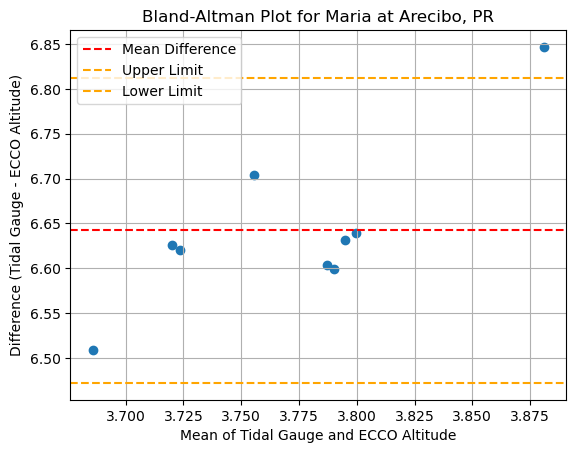

In [26]:
event = "Maria"
locat = "Arecibo, PR"
plot_bland_altman(event, locat, ar_allLoc_allEvent_tg, ar_allLoc_allEvent_sat, save_fig=True, plot_fig=True)

## Combined sources

### Normalized plot of **both** satellite and TG (not resampled)

> CAUTION: FOR THE FOLLOWING PLOT TO WORK, BE SURE THAT THE TG DATA HAS NOT BEEN RESAMPLED INSIDE THE `ar_allLoc_allEvent_tg` DICTIONARY.
> If it did, then go back to the `Second, getting the TG data` to set the `resample_tg` variable to `False``

/tmp/ipykernel_1627/3997397830.py:33: RuntimeWarning: Mean of empty slice.
  tg_values = tg_values - tg_values.mean()
/srv/conda/envs/notebook/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


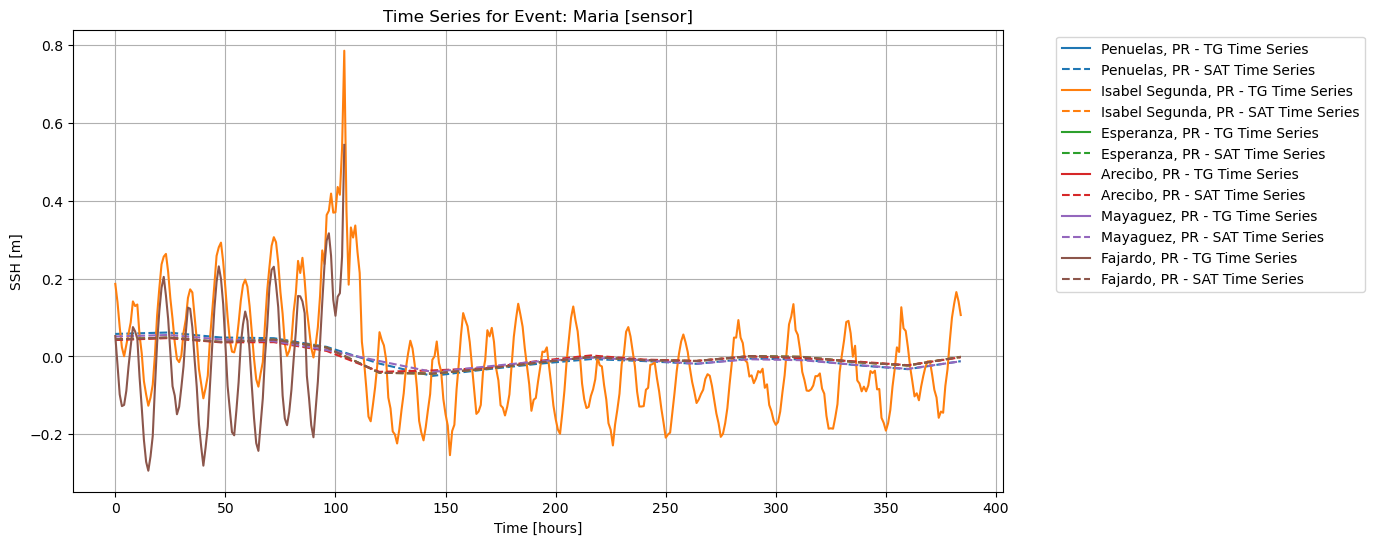

In [35]:
plot_time_series_combined(
    ar_allLoc_allEvent_tg, 
    ar_allLoc_allEvent_sat, 
    event = "Maria", 
    xlab="Time [hours]", ylab="SSH [m]",
    baseline_dict=True, 
    normalize_zero=True,
    )